# Customer Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from utils import print_results, plot_pr_curve, plot_roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - data deepdive

The first task in any data science or ML project is to understand and clean the data.

- Understand the data types for each feature
- Look for anomalies and missing values
- Understand the distributions for each feature

In [2]:
subscribers = pd.read_parquet('data/subscribers.gz.parquet', engine='fastparquet')
subscribers["Churn"] = (~subscribers["Date_Closed"].isnull()).astype(int)
subscribers.head()

,User_id,State,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,CustServ_Calls,Date_Created,Date_Closed,Churn
0,cfcd208495d565ef66e7dff9f98764da,KS,415,382-4657,no,yes,25,1,2017-07-26,None,0
1,c4ca4238a0b923820dcc509a6f75849b,OH,415,371-7191,no,yes,26,1,2017-08-16,None,0
2,c81e728d9d4c2f636f067f89cc14862c,NJ,415,358-1921,no,no,0,0,2017-07-17,None,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,OH,408,375-9999,yes,no,0,2,2017-09-08,None,0
4,a87ff679a2f3e71d9181a67b7542122c,OK,415,330-6626,yes,no,0,3,2017-09-17,None,0


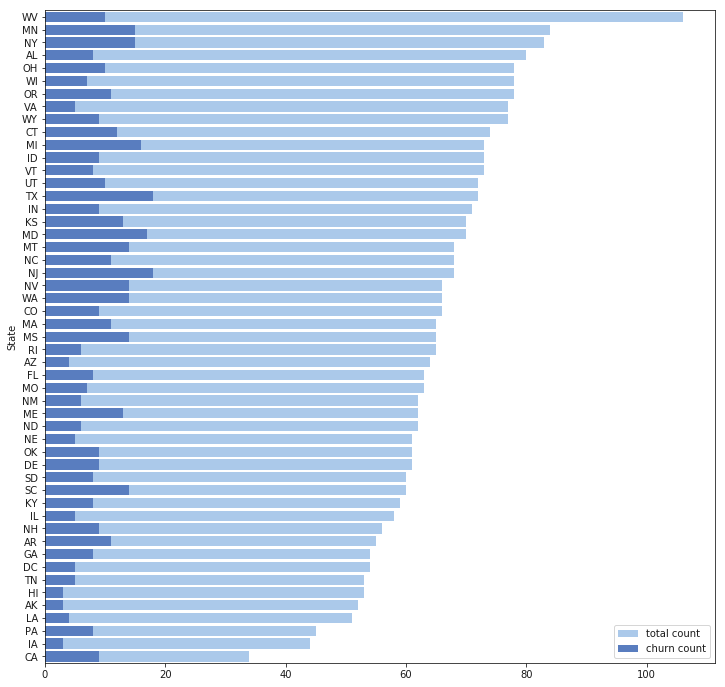

In [3]:
vcount = subscribers['State'].value_counts().reset_index()
vcount.columns = ['State', 'Total']

vcount2 = subscribers['State'].loc[subscribers['Churn']==1].value_counts().reset_index()
vcount2.columns = ['State', 'Left']

vcount = pd.merge(vcount, vcount2, on=['State'])
vcount = vcount.fillna(0)

plt.figure(figsize=(12, 12))
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="State", data=vcount, color="b", label='total count')

sns.set_color_codes("muted")
sns.barplot(x="Left", y="State", data=vcount, color="b", label='churn count')
plt.xlabel('')
plt.legend()
plt.show()

In [4]:
all_calls = pd.read_parquet('data/all_calls.gz.parquet', engine='fastparquet')
all_calls.head()

,User_id,Duration,Call_type
0,6766aa2750c19aad2fa1b32f36ed4aee,1.451465,Day
1,8fe0093bb30d6f8c31474bd0764e6ac0,0.318914,Eve
2,0234c510bc6d908b28c70ff313743079,2.111892,Day
3,dba132f6ab6a3e3d17a8d59e82105f4c,3.305193,Eve
4,d542599794c1cf067d90638b5d3911f3,1.924791,Night


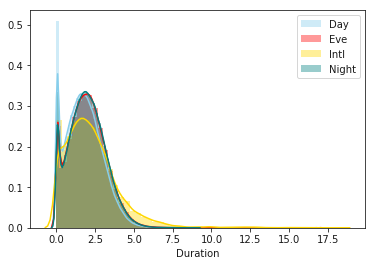

In [6]:
plt.figure()
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Day"],
             color="skyblue", label="Day")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Eve"],
             color="red", label="Eve")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Intl"],
             color="gold", label="Intl")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Night"],
             color="teal", label="Night")
plt.legend()
plt.show()

## Feature engineering and Preprocessing

One can increase the predictive quality of the data and reduce dimensionality using feature engineering.

- Feature crosses
- Embeddings
- PCA
- Categorical encoding

For example, we shall perform one-hot encoding on `Area_Code` and `State`.

```
Unique area codes =  [415 408 510]

Unique state codes = ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']
```

In [6]:
# Subscribers data
subscribers["Churn"] = (~subscribers["Date_Closed"].isnull()).astype(int)
subscribers = subscribers.drop(['Date_Created', 'Date_Closed', 'Phone'], axis=1)

# Calls data
all_calls = all_calls.groupby(['Call_type', 'User_id']).agg(['sum', 'count']).reset_index()
all_calls.columns = ['Call_type', 'User_id', 'Mins', 'Calls']
all_calls = all_calls.pivot(index='User_id', columns='Call_type', values=['Mins', 'Calls']).reset_index()
all_calls.columns = ['User_id', 'Day Mins', 'Eve Mins', 'Intl Mins', 'Night Mins',
                     'Day Calls', 'Eve Calls', 'Intl Calls', 'Night Calls']

# Joining
churn = pd.merge(subscribers, all_calls, on=['User_id'], how='left')
churn = churn.fillna(0)

# Categorical encoding
churn = churn.drop(['User_id'], axis=1)
churn['Area_Code'] = churn['Area_Code'].astype(object)
model_data = pd.get_dummies(churn)
model_data = model_data.drop(['Intl_Plan_no', 'VMail_Plan_no'], axis=1)

## Split train, validation and test data

In [7]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

X_train = train_data.drop('Churn', axis=1)
y_train = train_data['Churn']

X_val = validation_data.drop('Churn', axis=1)
y_val = validation_data['Churn']

## Train model

We use **LightGBM**: a gradient boosting framework that uses tree based learning algorithms.

In [8]:
gbm = lgb.LGBMClassifier(num_leaves=10, learning_rate=0.05, n_estimators=250)
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='accuracy',
        verbose=False)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=250, n_jobs=-1, num_leaves=10, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

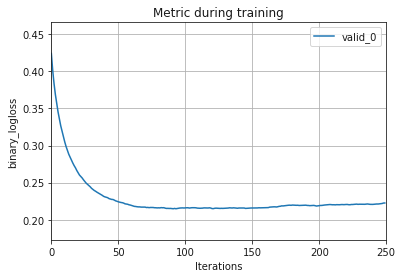

In [9]:
lgb.plot_metric(gbm)
plt.show()

## Evaluate using test set

In [10]:
X_test = test_data.drop('Churn', axis=1)
y_test = test_data['Churn']

y_probs = gbm.predict_proba(X_test)[:,1]

print_results(y_test, y_probs)

Confusion matrix:
[[282   4]
 [  9  39]]
Accuracy: 96.11%
Precision: 90.70%
Recall: 81.25%
F1 score: 85.71%


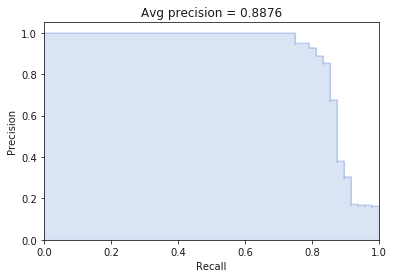

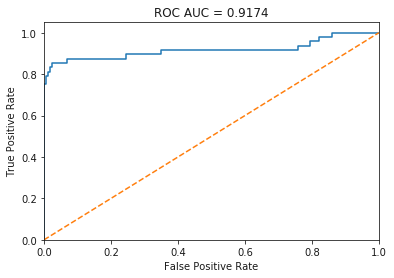

In [13]:
plot_pr_curve(y_test, y_probs)
plt.show()

plot_roc_curve(y_test, y_probs)
plt.show()

## Explainability

In [14]:
import shap
shap.initjs()

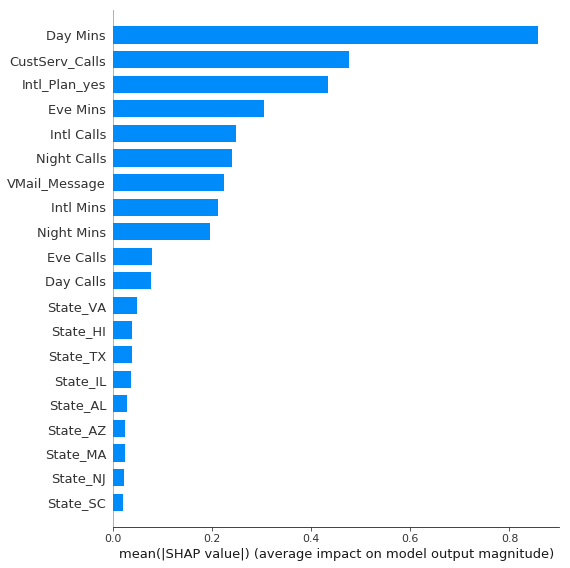

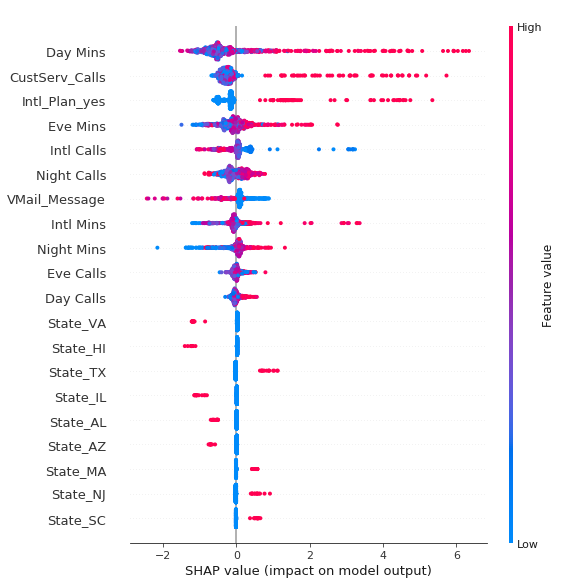

In [16]:
t_explainer = shap.TreeExplainer(gbm)
shap_values = t_explainer.shap_values(X_val)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_val, plot_type='bar')
shap.summary_plot(shap_values, X_val)